# Transfer Learning - Part 1 Feature Extraction

Transfer learning is leveraging a working models existing architecture and learned patterns for our own problem.

There are two main benefits:
* 1. Can leverage an existing neural network architecture proven to work on problems similar to our own
* 2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.


Things we'll do here:
* Introduce Transfer learning with Tensorflow
* Use a small dataset to experiment faster
* Build a transfer learning feature extraction model with Tensorflow Hub
* Use Tensorboard to track modeling experiments  and results

Other Notes:
* ImageNet has a wide variety of images we can train with
* EfficientNet architecture already works well on computer vision tasks
* We'll tune patterns/weights to our own problem
* Model performs better than from scratch

In [31]:
#Import sklearn before tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import pathlib
import numpy as np
import random
import urllib.request
import datetime

In [3]:
print(tf.__version__), sys.version, sklearn.show_versions()

2.4.1

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True
C:\Users\timar\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


(None,
 '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]',
 None)

# Test for Tensorflow GPU Support

GPU setup is documented here: https://www.tensorflow.org/install/gpu

In [4]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [5]:
# See if we have a GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("No GPU detected or you need to install the GPU version of tensorflow using pip install tensorflow-gpu.")

Default GPU Device:/device:GPU:0


# Downloading the Data

Get 10% of 10 food classes from food 101

* The zip file we use in this notebook [is here](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip).


In [6]:
#Setup variables for our data
if os.name == "nt":
    zip_download_file = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "c:/temp/data/10_food_classes_10_percent/"
    data_dir = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent"
else:
    zip_download_file = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "/home/pi/Dev/data/10_food_classes_10_percent/"
    data_dir = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent"

train_data_dir = data_dir + "/train"
test_data_dir = data_dir + "/test"

In [7]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
#if not os.path.isfile(zip_download_file):
#    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip -O $zip_download_file

In [8]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile(zip_download_file)
    zip_ref.extractall(path=zip_extract_location)
    zip_ref.close()

In [14]:
# Walk through the data directory and list number of files
# The extra file in our data directory is .DS_Store
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent
There are 10 directories and 0 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\ice_cream
There are 0 directorie

In [15]:
 # Another way to find out how many images are in a directory
 num_sushi_images_train = len(os.listdir(data_dir+"/train/sushi"))
 num_sushi_images_train

75

# 1. Visualize our Images

In [16]:
train_data_dir_path = pathlib.Path(train_data_dir)
for item in train_data_dir_path.glob("*"):
    print(item)

c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\chicken_curry
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\chicken_wings
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\fried_rice
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\grilled_salmon
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\hamburger
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\ice_cream
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\pizza
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\ramen
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\steak
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\sushi


In [18]:
# To visualize our imaages, first lets get our class names programatically
train_data_dir_path = pathlib.Path(data_dir+"/train/")
# Create a list of class names from the subdirectories
class_names = np.array(sorted([item.name for item in train_data_dir_path.glob("*")]))
#class_names = np.delete(class_names, np.where(class_names == ".DS_Store"))
print(class_names), len(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


(None, 10)

In [19]:
# Lets visualize our images
def view_random_images(target_dir, class_names, class_to_show=None, num_images=4, figsize=(10,10)):
    
    plt.figure(figsize=figsize)
    for i in range(num_images):
        # If a class was specified then show only that class
        if class_to_show:
            selected_class = class_to_show
        # Otherwise randomly pick classes
        else:
            selected_class = random.choice(class_names)

        # Setup the target directory (we'll view images from here)
        target_folder = target_dir + "/" + selected_class

        plt.subplot(1, num_images, i+1)

        #Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        
        # Read in the image and plot it using matplotlib
        img = mpimg.imread(target_folder + "/" + random_image[0])
        plt.imshow(img)
        plt.title(f"{selected_class}\nShape: {img.shape}\nFile: {random_image[0]}")
        plt.axis("off")

        print(f"Image Shape: {img.shape}")
        #return img

Image Shape: (384, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 384, 3)


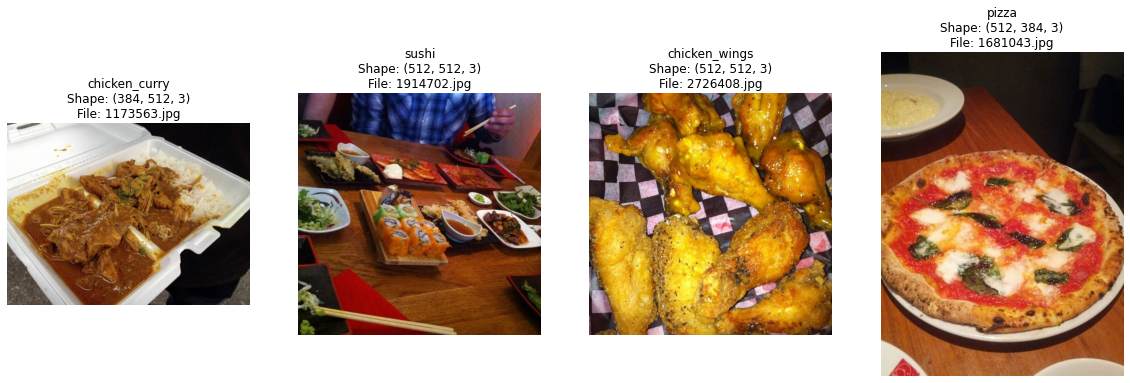

In [22]:
# View a random image from the training data set
view_random_images(
    target_dir=train_data_dir, 
    class_names = class_names,
    #Optionally pass in a specific class to show only images from that class
    #class_to_show = random.choice(class_names),
    num_images=4,
    figsize=(20,20)
)

# 2. Preprocess our Images

Our next step is to turn our data into batches and load our training and test sets.

A batch is a small subset of data. Rather than look at all ~10k images, a model might only look at 32 at a time. 

It does this for a couple of reasons:
* 10k images might not fit into the memory of the procesor
* Trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well.

Why 32?

Because 32 is good for your health per Yann Lecun. (google yann lecun batchsize, see his twitter post). Yann Lecun is a professor at NYU

In [25]:
#Constants
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Set the seed for reproducibility
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data in from directories and turn it into batches
# Setup paths to our data directories
# Use these variables extablished above
# train_data_dir
# test_data_dir

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size = BATCH_SIZE,
    # Reshape all the images to be the same size. 
    target_size = IMAGE_SHAPE,
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size = BATCH_SIZE,
    # Reshape all the images to be the same size. 
    target_size = IMAGE_SHAPE,
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [26]:
# Get a sample of train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [27]:
# How many batches are there
len(train_data) # This equals 1500 images divided by batch size of 32, rounded up

24

In [28]:
# Show a random image and its label from our Image Generator/Loader
import random
def view_random_image_from_data_generator_iterator(images, labels):
    # Return a number between 0 and the length of our images array (both included)
    random_number = random.randint(0, len(images)-1)
    label_index = np.argmax(labels[random_number])
    print(f"Showing image number {random_number}")
    image_shape = images[random_number].shape
    plt.imshow(images[random_number])
    plt.title(f"{class_names[label_index]}\nShape: {image_shape}")
    plt.axis(False)

Showing image number 7


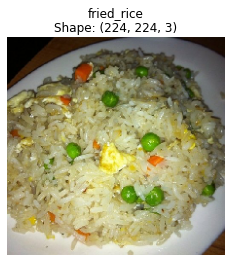

In [30]:
view_random_image_from_data_generator_iterator(images, labels)

# Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the ModelCheckpoint callbacks
* Stopping a model from training *before it trains too long and overfits) with the EarlyStopping callbac k


In [33]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir,        
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
    